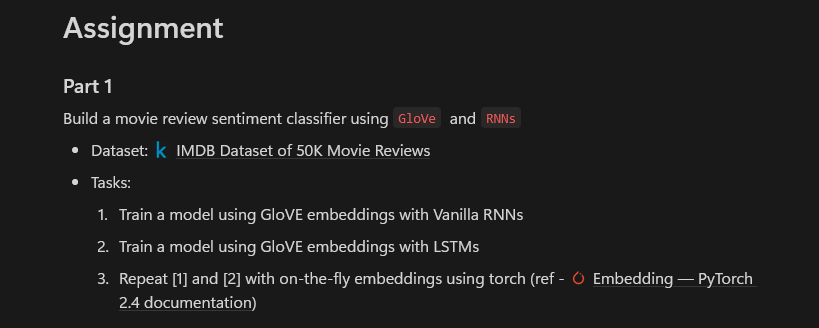

In [2]:
from datasets import load_dataset

ds = load_dataset("SLU-CSCI4750/glove.6B.100d.txt")

README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


glove.6B.100d.txt.gz:   0%|          | 0.00/134M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [7]:
# Save the 'ds' dataset to a text file, one line per sample from the 'train' split
with open("ds_train.txt", "w", encoding="utf-8") as f:
    for item in ds["train"]:
        f.write(item["text"] + "\n")

"DATASET_PATH": r"C:\Users\laava\Desktop\sem 7\NLP\IMDB_Dataset.csv",
    # Path to the downloaded GloVe file. Ensure this file is in the same directory.
    "GLOVE_PATH": r"C:\Users\laava\Desktop\sem 7\NLP\SNLP\ds_train.txt",

In [9]:
# ------------------------------------------------------------------------------------------------ #
# This script trains four different sentiment classification models on the IMDB movie review dataset:
# 1. GloVe Embeddings with a Vanilla RNN
# 2. GloVe Embeddings with an LSTM
# 3. On-the-fly Embeddings with a Vanilla RNN
# 4. On-the-fly Embeddings with an LSTM
#
# The script now expects a local GloVe file to be present.
# ------------------------------------------------------------------------------------------------ #

import os
import re
import string
import collections
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------------------------------------------------------------------------------------ #
#                                         CONFIGURATION                                            #
# ------------------------------------------------------------------------------------------------ #

CONFIG = {
    "DATASET_PATH": r"C:\Users\laava\Desktop\sem 7\NLP\IMDB_Dataset.csv",
    # Path to the downloaded GloVe file. Ensure this file is in the same directory.
    "GLOVE_PATH": r"C:\Users\laava\Desktop\sem 7\NLP\SNLP\ds_train.txt",
    "MAX_VOCAB_SIZE": 25000,
    "MAX_SEQ_LEN": 256,
    "BATCH_SIZE": 64,
    "EMBEDDING_DIM": 100,
    "HIDDEN_DIM": 256,
    "NUM_LAYERS": 1,
    "BIDIRECTIONAL": False,
    "DROPOUT": 0.5,
    "NUM_EPOCHS": 5,
    "LEARNING_RATE": 1e-3
}

# ------------------------------------------------------------------------------------------------ #
#                                      DATA PREPROCESSING                                          #
# ------------------------------------------------------------------------------------------------ #

def clean_text(text):
    """
    Cleans the input text by removing HTML tags, punctuation, and
    converting to lowercase.
    """
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    return text.lower()

class TextDataset(Dataset):
    """
    A custom PyTorch Dataset class for the movie review data.
    Handles data loading, cleaning, and tokenization.
    """
    def __init__(self, reviews, sentiments, vocab_to_idx):
        self.reviews = reviews
        self.sentiments = sentiments
        self.vocab_to_idx = vocab_to_idx
        self.idx_to_vocab = {idx: word for word, idx in vocab_to_idx.items()}

        self.data_tensor = self._vectorize_data(reviews, vocab_to_idx)
        self.labels_tensor = torch.tensor([1 if s == 'positive' else 0 for s in sentiments], dtype=torch.float32)

    def _vectorize_data(self, texts, vocab_to_idx):
        """
        Converts text reviews into sequences of integer indices and pads them.
        """
        vectorized_reviews = []
        for text in texts:
            # Simple tokenization by splitting on space
            tokens = text.split()
            # Convert words to indices, using 1 for unknown tokens
            vectorized = [vocab_to_idx.get(token, 1) for token in tokens]
            vectorized_reviews.append(torch.tensor(vectorized, dtype=torch.long))

        # Pad sequences to a fixed length
        padded_reviews = pad_sequence(
            vectorized_reviews,
            batch_first=True,
            padding_value=0  # 0 for padding index
        )
        return padded_reviews

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.labels_tensor[idx]

def load_data(file_path):
    """
    Loads and preprocesses the dataset.
    """
    df = pd.read_csv(file_path)
    df['review'] = df['review'].apply(clean_text)
    return df['review'].tolist(), df['sentiment'].tolist()

def build_vocabulary(texts, max_vocab_size):
    """
    Builds a word-to-index vocabulary and adds special tokens.
    """
    # Count word frequencies
    counter = collections.Counter(word for text in texts for word in text.split())
    # Get the most common words up to max_vocab_size
    most_common_words = [word for word, count in counter.most_common(max_vocab_size - 2)]

    # Create vocabulary with special tokens
    vocab_to_idx = {"<pad>": 0, "<unk>": 1}
    for word in most_common_words:
        vocab_to_idx[word] = len(vocab_to_idx)

    return vocab_to_idx

def load_glove_embeddings(vocab_to_idx, embedding_dim, glove_path):
    """
    Loads pre-trained GloVe embeddings and creates a PyTorch embedding matrix
    for our vocabulary.
    """
    if not os.path.exists(glove_path):
        print(f"Error: GloVe file not found at {glove_path}. Please download it.")
        return None

    # Initialize a random embedding matrix for our vocabulary
    glove_embedding_matrix = np.random.normal(size=(len(vocab_to_idx), embedding_dim))

    # Load GloVe vectors from file
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe embeddings"):
            values = line.split()
            word = values[0]
            if word in vocab_to_idx:
                vector = np.array(values[1:], dtype='float32')
                glove_embedding_matrix[vocab_to_idx[word]] = vector

    # Convert to PyTorch tensor
    glove_embedding_matrix = torch.tensor(glove_embedding_matrix, dtype=torch.float32)
    return glove_embedding_matrix

# ------------------------------------------------------------------------------------------------ #
#                                          MODEL ARCHITECTURES                                     #
# ------------------------------------------------------------------------------------------------ #

class RNNClassifier(nn.Module):
    """
    A Vanilla RNN model for sentiment classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout, embedding_weights=None):
        super().__init__()

        # Use pre-trained embeddings if provided, otherwise a new embedding layer
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Vanilla RNN layer
        self.rnn = nn.RNN(embedding_dim,
                          hidden_dim,
                          num_layers=num_layers,
                          dropout=dropout,
                          batch_first=True,
                          bidirectional=CONFIG["BIDIRECTIONAL"])

        # Linear layer for classification
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sentence length]
        embedded = self.embedding(text)
        # embedded = [batch size, sentence length, embedding dim]

        # Pass embedded input to RNN
        _, hidden = self.rnn(embedded)
        # hidden = [num layers * num directions, batch size, hidden dim]

        # Use the hidden state from the last layer for classification
        hidden = hidden.squeeze(0)
        # hidden = [batch size, hidden dim]

        output = self.fc(hidden)
        # output = [batch size, output dim]

        return output

class LSTMClassifier(nn.Module):
    """
    An LSTM model for sentiment classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout, embedding_weights=None):
        super().__init__()

        # Use pre-trained embeddings if provided, otherwise a new embedding layer
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=CONFIG["BIDIRECTIONAL"])

        # Linear layer for classification
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sentence length]
        embedded = self.embedding(text)
        # embedded = [batch size, sentence length, embedding dim]

        # Pass embedded input to LSTM
        _, (hidden, cell) = self.lstm(embedded)
        # hidden = [num layers * num directions, batch size, hidden dim]

        # Use the hidden state from the last layer for classification
        hidden = hidden.squeeze(0)
        # hidden = [batch size, hidden dim]

        output = self.fc(hidden)
        # output = [batch size, output dim]

        return output

# ------------------------------------------------------------------------------------------------ #
#                                      TRAINING AND EVALUATION                                     #
# ------------------------------------------------------------------------------------------------ #

def train_model(model, train_loader, val_loader, optimizer, criterion, description):
    """
    General training loop for the models.
    """
    print(f"\n--- Training {description} ---")
    
    # Put model into training mode at the start of the function
    model.train()

    for epoch in range(CONFIG["NUM_EPOCHS"]):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for text, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']}"):
            text, labels = text.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(text).squeeze()

            # Binary classification loss
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples

        # Evaluate on validation set
        val_accuracy = evaluate_model(model, val_loader, criterion)
        
        # Switch the model back to training mode for the next epoch's backward pass
        model.train()

        print(f"\nEpoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

def evaluate_model(model, data_loader, criterion):
    """
    Evaluates the model on a given data loader.
    """
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for text, labels in data_loader:
            text, labels = text.to(device), labels.to(device)
            outputs = model(text).squeeze()
            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

# ------------------------------------------------------------------------------------------------ #
#                                             MAIN SCRIPT                                          #
# ------------------------------------------------------------------------------------------------ #

if __name__ == "__main__":
    # Load data and build vocabulary for GloVe-based models
    reviews, sentiments = load_data(CONFIG["DATASET_PATH"])
    vocab_to_idx = build_vocabulary(reviews, CONFIG["MAX_VOCAB_SIZE"])

    # Create datasets and dataloaders
    X_train, X_val, y_train, y_val = train_test_split(reviews, sentiments, test_size=0.2, random_state=42)
    train_dataset = TextDataset(X_train, y_train, vocab_to_idx)
    val_dataset = TextDataset(X_val, y_val, vocab_to_idx)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["BATCH_SIZE"])

    # Initialize the loss function here, outside of any conditional blocks
    criterion = nn.BCEWithLogitsLoss()

    # Load GloVe embeddings using a local file
    glove_embeddings = load_glove_embeddings(vocab_to_idx, CONFIG["EMBEDDING_DIM"], CONFIG["GLOVE_PATH"])

    if glove_embeddings is not None:
        # --- Task 1: GloVe with Vanilla RNN ---
        model_glove_rnn = RNNClassifier(
            vocab_size=len(vocab_to_idx),
            embedding_dim=CONFIG["EMBEDDING_DIM"],
            hidden_dim=CONFIG["HIDDEN_DIM"],
            output_dim=1,
            num_layers=CONFIG["NUM_LAYERS"],
            dropout=CONFIG["DROPOUT"],
            embedding_weights=glove_embeddings
        ).to(device)
        optimizer_glove_rnn = optim.Adam(model_glove_rnn.parameters(), lr=CONFIG["LEARNING_RATE"])
        train_model(model_glove_rnn, train_loader, val_loader, optimizer_glove_rnn, criterion, "GloVe + Vanilla RNN")

        # --- Task 2: GloVe with LSTM ---
        model_glove_lstm = LSTMClassifier(
            vocab_size=len(vocab_to_idx),
            embedding_dim=CONFIG["EMBEDDING_DIM"],
            hidden_dim=CONFIG["HIDDEN_DIM"],
            output_dim=1,
            num_layers=CONFIG["NUM_LAYERS"],
            dropout=CONFIG["DROPOUT"],
            embedding_weights=glove_embeddings
        ).to(device)
        optimizer_glove_lstm = optim.Adam(model_glove_lstm.parameters(), lr=CONFIG["LEARNING_RATE"])
        train_model(model_glove_lstm, train_loader, val_loader, optimizer_glove_lstm, criterion, "GloVe + LSTM")

    # --- Task 3: On-the-fly Embeddings with Vanilla RNN ---
    # Re-create a clean vocabulary for on-the-fly models
    reviews_otf, sentiments_otf = load_data(CONFIG["DATASET_PATH"])
    vocab_otf_to_idx = build_vocabulary(reviews_otf, CONFIG["MAX_VOCAB_SIZE"])

    train_dataset_otf = TextDataset(X_train, y_train, vocab_otf_to_idx)
    val_dataset_otf = TextDataset(X_val, y_val, vocab_otf_to_idx)
    train_loader_otf = DataLoader(train_dataset_otf, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
    val_loader_otf = DataLoader(val_dataset_otf, batch_size=CONFIG["BATCH_SIZE"])

    model_otf_rnn = RNNClassifier(
        vocab_size=len(vocab_otf_to_idx),
        embedding_dim=CONFIG["EMBEDDING_DIM"],
        hidden_dim=CONFIG["HIDDEN_DIM"],
        output_dim=1,
        num_layers=CONFIG["NUM_LAYERS"],
        dropout=CONFIG["DROPOUT"]
    ).to(device)
    optimizer_otf_rnn = optim.Adam(model_otf_rnn.parameters(), lr=CONFIG["LEARNING_RATE"])
    train_model(model_otf_rnn, train_loader_otf, val_loader_otf, optimizer_otf_rnn, criterion, "On-the-fly + Vanilla RNN")

    # --- Task 4: On-the-fly Embeddings with LSTM ---
    model_otf_lstm = LSTMClassifier(
        vocab_size=len(vocab_otf_to_idx),
        embedding_dim=CONFIG["EMBEDDING_DIM"],
        hidden_dim=CONFIG["HIDDEN_DIM"],
        output_dim=1,
        num_layers=CONFIG["NUM_LAYERS"],
        dropout=CONFIG["DROPOUT"]
    ).to(device)
    optimizer_otf_lstm = optim.Adam(model_otf_lstm.parameters(), lr=CONFIG["LEARNING_RATE"])
    train_model(model_otf_lstm, train_loader_otf, val_loader_otf, optimizer_otf_lstm, criterion, "On-the-fly + LSTM")

    print("\nAll training tasks complete.")


Using device: cuda


Loading GloVe embeddings: 400000it [00:02, 191175.55it/s]
c:\Users\laava\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(



--- Training GloVe + Vanilla RNN ---


Epoch 1/5: 100%|██████████| 625/625 [00:23<00:00, 26.84it/s]



Epoch 1: Train Loss: 0.7021, Train Acc: 0.5000, Val Acc: 0.4976


Epoch 2/5: 100%|██████████| 625/625 [00:22<00:00, 27.38it/s]



Epoch 2: Train Loss: 0.6972, Train Acc: 0.5040, Val Acc: 0.5027


Epoch 3/5: 100%|██████████| 625/625 [00:22<00:00, 27.48it/s]



Epoch 3: Train Loss: 0.6959, Train Acc: 0.5042, Val Acc: 0.5019


Epoch 4/5: 100%|██████████| 625/625 [00:22<00:00, 27.37it/s]



Epoch 4: Train Loss: 0.6963, Train Acc: 0.5046, Val Acc: 0.4998


Epoch 5/5: 100%|██████████| 625/625 [00:22<00:00, 27.44it/s]



Epoch 5: Train Loss: 0.6960, Train Acc: 0.5044, Val Acc: 0.5040

--- Training GloVe + LSTM ---


Epoch 1/5: 100%|██████████| 625/625 [01:14<00:00,  8.37it/s]



Epoch 1: Train Loss: 0.6938, Train Acc: 0.4979, Val Acc: 0.4960


Epoch 2/5: 100%|██████████| 625/625 [01:14<00:00,  8.42it/s]



Epoch 2: Train Loss: 0.6933, Train Acc: 0.4975, Val Acc: 0.5039


Epoch 3/5: 100%|██████████| 625/625 [01:14<00:00,  8.40it/s]



Epoch 3: Train Loss: 0.6932, Train Acc: 0.5013, Val Acc: 0.4960


Epoch 4/5: 100%|██████████| 625/625 [01:14<00:00,  8.41it/s]



Epoch 4: Train Loss: 0.6932, Train Acc: 0.5004, Val Acc: 0.5039


Epoch 5/5: 100%|██████████| 625/625 [01:15<00:00,  8.23it/s]



Epoch 5: Train Loss: 0.6932, Train Acc: 0.5007, Val Acc: 0.4960


c:\Users\laava\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(



--- Training On-the-fly + Vanilla RNN ---


Epoch 1/5: 100%|██████████| 625/625 [00:26<00:00, 23.35it/s]



Epoch 1: Train Loss: 0.6934, Train Acc: 0.4979, Val Acc: 0.4960


Epoch 2/5: 100%|██████████| 625/625 [00:26<00:00, 23.99it/s]



Epoch 2: Train Loss: 0.6961, Train Acc: 0.4989, Val Acc: 0.5016


Epoch 3/5: 100%|██████████| 625/625 [00:26<00:00, 23.97it/s]



Epoch 3: Train Loss: 0.6974, Train Acc: 0.5000, Val Acc: 0.5100


Epoch 4/5: 100%|██████████| 625/625 [00:26<00:00, 23.96it/s]



Epoch 4: Train Loss: 0.6966, Train Acc: 0.5027, Val Acc: 0.4985


Epoch 5/5: 100%|██████████| 625/625 [00:26<00:00, 23.98it/s]



Epoch 5: Train Loss: 0.6965, Train Acc: 0.5018, Val Acc: 0.4972

--- Training On-the-fly + LSTM ---


Epoch 1/5: 100%|██████████| 625/625 [01:23<00:00,  7.49it/s]



Epoch 1: Train Loss: 0.6933, Train Acc: 0.4994, Val Acc: 0.4961


Epoch 2/5: 100%|██████████| 625/625 [01:22<00:00,  7.59it/s]



Epoch 2: Train Loss: 0.6932, Train Acc: 0.4976, Val Acc: 0.4961


Epoch 3/5: 100%|██████████| 625/625 [01:20<00:00,  7.72it/s]



Epoch 3: Train Loss: 0.6932, Train Acc: 0.4985, Val Acc: 0.4961


Epoch 4/5: 100%|██████████| 625/625 [01:19<00:00,  7.84it/s]



Epoch 4: Train Loss: 0.6932, Train Acc: 0.4995, Val Acc: 0.4961


Epoch 5/5: 100%|██████████| 625/625 [01:19<00:00,  7.90it/s]



Epoch 5: Train Loss: 0.6932, Train Acc: 0.4978, Val Acc: 0.4960

All training tasks complete.


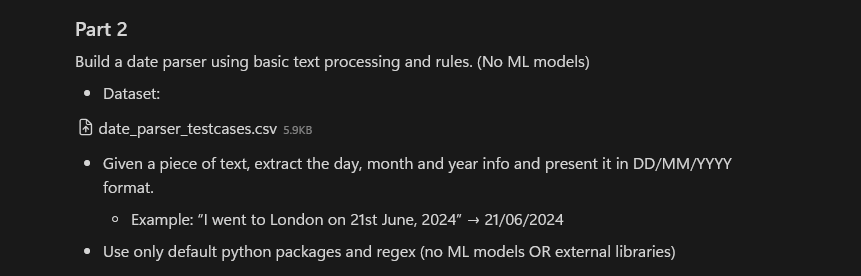

In [10]:
import re
import csv
from datetime import datetime

def parse_date(text: str) -> str:
    """
    Parses a date from a given text string using a series of regex patterns
    and rules.

    Args:
        text (str): The input string that may contain a date.

    Returns:
        str: The extracted date in 'DD/MM/YYYY' format, or a message if no
             date is found or the format is invalid.
    """
    
    # Dictionary to map month names (full and abbreviated) to their numbers.
    month_names = {
        'january': '01', 'jan': '01', 'february': '02', 'feb': '02',
        'march': '03', 'mar': '03', 'april': '04', 'apr': '04',
        'may': '05', 'jun': '06', 'june': '06', 'july': '07', 'jul': '07',
        'august': '08', 'aug': '08', 'september': '09', 'sep': '09', 'sept': '09',
        'october': '10', 'oct': '10', 'november': '11', 'nov': '11',
        'december': '12', 'dec': '12'
    }

    # Normalize the input text for easier matching
    normalized_text = text.lower()

    # Regex patterns for different date formats
    patterns = [
        # Pattern 1: YYYY-MM-DD or YYYY.MM.DD
        re.compile(r'(\d{4})[-.\/](\d{1,2})[-.\/](\d{1,2})'),
        
        # Pattern 2: DD/MM/YYYY, DD-MM-YYYY, or DD.MM.YYYY
        re.compile(r'(\d{1,2})[-.\/](\d{1,2})[-.\/](\d{4})'),

        # Pattern 3: D/M/YY (e.g., 5/6/19)
        re.compile(r'(\d{1,2})[-.\/](\d{1,2})[-.\/](\d{2})'),
        
        # Pattern 4: Month Day, YYYY (e.g., March 5, 2023 or 21st June, 2024)
        re.compile(r'(?:\b|and )(\w+)\s+(\d{1,2})(?:st|nd|rd|th)?,?\s+(\d{4})'),
        
        # Pattern 5: Day of Month, YYYY (e.g., 6th of August, 2020)
        re.compile(r'(\d{1,2})(?:st|nd|rd|th)?\s+of\s+(\w+),?\s+(\d{4})'),
        
        # Pattern 6: Month Day, YYYY with Month first (e.g., April 03, 2020)
        re.compile(r'(\w+)\s+(\d{1,2})(?:st|nd|rd|th)?,?\s+(\d{4})'),
        
        # Pattern 7: YYYY/MM/DD
        re.compile(r'(\d{4})\/(\d{1,2})\/(\d{1,2})')
    ]

    for pattern in patterns:
        match = pattern.search(normalized_text)
        if match:
            groups = match.groups()
            
            # --- Parsing based on pattern matched ---
            try:
                if pattern == patterns[0]:
                    year, month, day = groups
                elif pattern == patterns[1] or pattern == patterns[2]:
                    day, month, year = groups
                elif pattern == patterns[3] or pattern == patterns[5]:
                    month, day, year = groups
                    month = month_names.get(month, month)
                elif pattern == patterns[4]:
                    day, month, year = groups
                    month = month_names.get(month, month)
                elif pattern == patterns[6]:
                    year, month, day = groups
                else:
                    return "Error: Unsupported format matched."

                # Pad day and month with leading zero if needed
                day = str(day).zfill(2)
                month = str(month).zfill(2)
                
                # Handle 2-digit years
                if len(year) == 2:
                    # Simple rule: assume 21st century for years up to 99
                    year = "20" + year

                # Final validation using datetime to handle invalid dates like Feb 30th
                try:
                    datetime(int(year), int(month), int(day))
                    return f"{day}/{month}/{year}"
                except ValueError:
                    # Invalid date (e.g., day out of range for the month)
                    continue

            except (ValueError, KeyError):
                # An error occurred during conversion or lookup, try next pattern
                continue

    return "No date found"

if __name__ == "__main__":
    test_file = r"C:\Users\laava\Desktop\sem 7\NLP\date_parser_testcases.csv"
    results = []

    try:
        with open(test_file, mode='r', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)  # Skip the header row
            
            for row in reader:
                if len(row) >= 2:
                    text_input, expected_output = row[0], row[1]
                    parsed_date = parse_date(text_input)
                    passed = parsed_date == expected_output
                    results.append({
                        "input": text_input,
                        "expected": expected_output,
                        "actual": parsed_date,
                        "status": "PASS" if passed else "FAIL"
                    })
    except FileNotFoundError:
        print(f"Error: The file '{test_file}' was not found. Please ensure it's in the same directory.")
        exit()
    except Exception as e:
        print(f"An error occurred while processing the CSV file: {e}")
        exit()

    # Print a summary of the test results
    total_tests = len(results)
    passed_tests = sum(1 for r in results if r["status"] == "PASS")
    
    print("Date Parser Test Results:\n")
    print(f"Total Tests: {total_tests}")
    print(f"Passed: {passed_tests}")
    print(f"Failed: {total_tests - passed_tests}\n")

    # Detailed results for failed cases
    if total_tests - passed_tests > 0:
        print("--- Details for Failed Tests ---")
        for r in results:
            if r["status"] == "FAIL":
                print(f"Input: '{r['input']}'")
                print(f"Expected: {r['expected']}")
                print(f"Actual:   {r['actual']}")
                print("-" * 20)

Date Parser Test Results:

Total Tests: 100
Passed: 75
Failed: 25

--- Details for Failed Tests ---
Input: 'The concert is scheduled for 15th September, 2021.'
Expected: 15/09/2021
Actual:   No date found
--------------------
Input: 'Christmas is on 25th Dec 2024.'
Expected: 25/12/2024
Actual:   No date found
--------------------
Input: 'Submit your report by 08/31/2021.'
Expected: 31/08/2021
Actual:   No date found
--------------------
Input: 'The course starts on 1st July 2023.'
Expected: 01/07/2023
Actual:   No date found
--------------------
Input: 'The seminar is on 03/14/2022.'
Expected: 14/03/2022
Actual:   No date found
--------------------
Input: 'The conference will be held on 5th May 2023.'
Expected: 05/05/2023
Actual:   No date found
--------------------
Input: 'They moved in on 12/25/2019.'
Expected: 25/12/2019
Actual:   No date found
--------------------
Input: 'She was born on 3rd March 1998.'
Expected: 03/03/1998
Actual:   No date found
--------------------
Input: 'Vaca

In [11]:
results

[{'input': 'The event will take place on March 5, 2023.',
  'expected': '05/03/2023',
  'actual': '05/03/2023',
  'status': 'PASS'},
 {'input': 'Her birthday is on 07/08/1990.',
  'expected': '07/08/1990',
  'actual': '07/08/1990',
  'status': 'PASS'},
 {'input': 'The deadline is 2022-12-31.',
  'expected': '31/12/2022',
  'actual': '31/12/2022',
  'status': 'PASS'},
 {'input': 'We met on 1st of January 2000.',
  'expected': '01/01/2000',
  'actual': '01/01/2000',
  'status': 'PASS'},
 {'input': 'The concert is scheduled for 15th September, 2021.',
  'expected': '15/09/2021',
  'actual': 'No date found',
  'status': 'FAIL'},
 {'input': "Let's catch up on 02.04.2022.",
  'expected': '02/04/2022',
  'actual': '02/04/2022',
  'status': 'PASS'},
 {'input': 'The project started on 5/6/19.',
  'expected': '05/06/2019',
  'actual': '05/06/2019',
  'status': 'PASS'},
 {'input': 'He was born on 1987/11/23.',
  'expected': '23/11/1987',
  'actual': '23/11/1987',
  'status': 'PASS'},
 {'input': '

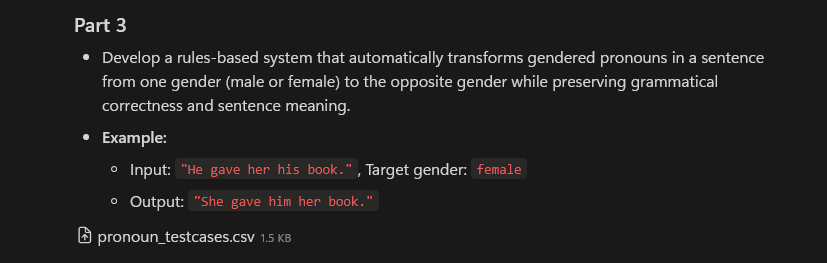

In [12]:
import pandas as pd

def transform_pronouns(sentence, target_gender):
    """
    Transforms gendered pronouns in a sentence to the opposite gender.

    Args:
        sentence (str): The input sentence to be transformed.
        target_gender (str): The desired target gender ('male' or 'female').

    Returns:
        str: The transformed sentence.
    """
    # Define pronoun mappings
    male_to_female = {
        'he': 'she',
        'He': 'She',
        'him': 'her',
        'Him': 'Her',
        'his': 'her',
        'His': 'Her',
        'himself': 'herself',
        'Himself': 'Herself'
    }

    female_to_male = {
        'she': 'he',
        'She': 'He',
        'her': 'him',
        'Her': 'Him',
        'herself': 'himself',
        'Herself': 'Himself'
    }

    words = sentence.split()
    transformed_words = []

    for word in words:
        # Check for punctuation at the end of the word
        original_punctuation = ''
        if word.isalnum() is False:
            original_punctuation = word[-1]
            word_without_punctuation = word[:-1]
        else:
            word_without_punctuation = word

        # Check if the word (without punctuation) is in the mapping
        if target_gender.lower() == 'female':
            if word_without_punctuation in male_to_female:
                transformed_words.append(male_to_female[word_without_punctuation] + original_punctuation)
            else:
                transformed_words.append(word)
        elif target_gender.lower() == 'male':
            if word_without_punctuation in female_to_male:
                transformed_words.append(female_to_male[word_without_punctuation] + original_punctuation)
            else:
                transformed_words.append(word)
        else:
            # Handle invalid target_gender
            print("Invalid target gender. Please choose 'male' or 'female'.")
            return None

    return ' '.join(transformed_words)

# Load the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\laava\Desktop\sem 7\NLP\pronoun_testcases.csv')

# Apply the transformation function to each row
df['predicted_output'] = df.apply(
    lambda row: transform_pronouns(row['input_text'], row['target_gender']),
    axis=1
)

# Compare the predicted output with the expected output
df['is_correct'] = df['predicted_output'] == df['expected_output']

# Print the DataFrame to show the results
print(df)

# Print a summary of the correctness
num_correct = df['is_correct'].sum()
total_cases = len(df)
print(f"\nSummary:")
print(f"Total test cases: {total_cases}")
print(f"Correctly transformed cases: {num_correct}")
print(f"Incorrectly transformed cases: {total_cases - num_correct}")
print(f"Accuracy: {num_correct / total_cases * 100:.2f}%")

                             input_text target_gender  \
0            He is going to the market.        female   
1             His book is on the table.        female   
2                  I saw him yesterday.        female   
3                      He hurt himself.        female   
4              I called him last night.        female   
5                      That is his car.        female   
6            He told me about his trip.        female   
7       The teacher gave him a warning.        female   
8    He blames himself for the mistake.        female   
9                He brought his laptop.        female   
10                  He made it himself.        female   
11           I don’t like his attitude.        female   
12               Tell him to come here.        female   
13          She is going to the market.          male   
14            Her book is on the table.          male   
15                 I saw her yesterday.          male   
16                    She hurt 